# The Early Net: Preventing Stroke in Older Adults with Proactive BP Screening

Zhang Chenge (157)

## Executive Summary

Research suggests that
-	(8) Ambulatory BP monitoring: profiling BP can identify higher risk of stroke
-	(10) BP variation (BPV) associated with increased risk of stroke, especially in terms of time of variation.
-	(13) BP trajectory related to clinical outcomes of IS patients

Further investigations mandate a dual approach…

## Literature Review

### Problem Statement

Stroke occurs when blood supply to a part of brain is cut off, causing brain tissue damage, while it is well-known that hypertension (HT), or high blood pressure (BP), is a leading cause of stroke, and poor treatment of HT often results in higher stroke risk. Additionally, having a TIA (triansient ischemic attack) means a higher risk of developing stroke (Centers for Disease Control and Prevention, 2024). In Hong Kong, the CDCC Pilot Scheme (ref) was introduced to help supporting treating hypertension, but the scheme only subsidizes 6 annual consultations, with no mention of implementing proactive BP monitoring. Therefore, it is not guaranteed for the HT condition of the patient to be treated optimally, and between consultations, the patient’s BP cannot be guaranteed to be proactively monitored.

### Significance

Causing 2,911 deaths, stroke was the 4th most common cause of death in Hong Kong in 2024 (Centre for Health Prevention, 2025), and has a higher incidence among those aged over 55 (Boehme et al., 2017). Also, it is found that poorly treated and undetected HT leads to higher hazard risks (HR) of stroke than in those whose HT is controlled (Han et al., 2017). If the population particularly susceptible to stroke can be screened at an early stage (by monitoring the ambulatory BP), and intervening with suitable BP management treatments, stroke could be prevented, saving thousands of lives each year.

### Objectives

This study aims to identify the necessity for frequent, proactive BP monitoring for preventing stroke in the aged population. Specifically,

1.	Compare existing datasets to find correlation between BP and stroke, and longitudinal BP trends predict first-ever stroke occurrence in adults aged 55-80.
2.	Identify high-risk groups with long-term health issues or lifestyle factors (e.g., diet or consumption of certain drinks) that could lead to higher stroke risk, therefore defining groups for prioritized BP screening.
3.	Assess whether baseline treatment status (e.g., use of HT drugs or diabetes treatment) could mediate or reduce correlation between BP values and stroke risk.
4.	Explore correlation between recent symptoms and short-term stroke risk.
5.	Generate candidate, easy to apply screening criteria (rule sets or risk score cut-points) that prioritize individuals for proactive monitoring, and report their predictive performance and likely population yield.

## Data analysis

### Methodology

A retrospective cohort is used to compare trends in BP (systolic and diastolic) that may lead to stroke, and correlation between symptoms reported at wave 
preceeding stroke to find correlation between occurrence of symptoms and stroke risk.

At baseline, individuals aged 55-80 and free of stroke are included. Only individuals that appeared across 3 or more “waves” (statistical periods) are included.

### Data Import
This part processes necesary data to prepare for analysis.

Data source: https://chns.cpc.unc.edu/

China Health and Nutrition Survey. Licensed under CC0.

#### Abbrevations
- CHNS - China Health and Nutrition Survey
- CHNS_Idv - Individual datasets from CHNS

All datasets provided are in the SAS format. They are read into Pandas `DataFrame`s first for further processing.

In [57]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
from matplotlib import pyplot as plt
import scipy.stats as stats

from IPython.display import HTML, display  # For table output visualization

%matplotlib widget

#### Clean up Data

CHNS uses a set of codes to name their data colums, which are available with the datasets. Individuals have a unique ID assigned to them, which is persistent across waves (years where CHNS is taken place). This means that one can combine individual data across waves for longitudinal study.

For the sake of simplicity, only statistical data collected that are related to cardiovascular and cerebrovascular problems are taken into consideration. The following are factors included.

- Age
- Gender
- Recent symptoms
    - Had a headache in last 4 weeks?
    - Had chest pain in last 4 weeks?
    - Felt exhausted in last 4 weeks?
    - Had bleeding of unknown cause in last 4 weeks?
    - Had weight loss of unknown cause in last 4 weeks?
- Systolic blood pressure (take mean of 3 values)
- Diastolic blood pressure (take mean of 3 values)
- BMI (calculated from height and weight)
    - Height
    - Weight
- Has hypertension?
    - Is the patient taking HT drugs?
- Has diabetes?
- Has myocardiac infarction (MI)?
- Has apoplexy?
- Had a transient ischemic attack (TIA) in the past year?
- Had ever smoked?
    - Still smoking or quitted?
    - Number of cigarettes smoked per day.
- Drinks beer?
    - Number of bottles of beer per week
    - Frequency of drinking beer per week
- Drinks tea?
    - Number of bottles of tea per week
    - Frequency of drinking tea per week
- Drinks coffee?
    - Number of bottles of coffee per week
    - Frequency of drinking coffee per week

Frequency of all `_Freq` columns are encoded as follows:

1. Almost every day
2. 4-5 times a week
3. 2-3 times a week
4. No more than once a week
5. 2-3 times in past 30 days
6. Only once in past 30 days
7. None in past 30 days

In [2]:
hlth_data = pd.read_sas("CHNS_Idv/hlth_12.sas7bdat")

hlth_data["wave"] = hlth_data["wave"].astype(int)
hlth_data["IDind"] = hlth_data["IDind"].astype(int)
hlth_cols = {
    "IDind"    : "ID",
    "M24B_3"   : "Headache_Last4",
    "M24B_7"   : "Chestpain_Last4",
    "M24B_14"  : "Exhaustion_Last4",
    "M24B_15"  : "Unknown_Bleed_Last4",
    "M24B_16"  : "Unknown_WghtLoss_Last4",
    "M26"      : "Sought_Medcare",
    "wave"     : "Wave",
}

hlth_data = hlth_data[[*hlth_cols.keys()]]
hlth_data = hlth_data.rename(columns=hlth_cols)
hlth_data = hlth_data.sort_values("ID")

hlth_data = hlth_data.fillna(0)
    
hlth_data = hlth_data.reset_index(drop=True)
hlth_data

,ID,Headache_Last4,Chestpain_Last4,Exhaustion_Last4,Unknown_Bleed_Last4,Unknown_WghtLoss_Last4,Sought_Medcare,Wave
0,111101001001,1.0,0.0,0.0,0.0,0.0,0.0,2011
1,111101001001,0.0,0.0,0.0,0.0,0.0,0.0,2015
2,111101001002,0.0,0.0,0.0,0.0,0.0,0.0,2011
3,111101001002,0.0,0.0,0.0,0.0,0.0,0.0,2015
4,111101002001,1.0,0.0,0.0,0.0,0.0,0.0,2011
...,...,...,...,...,...,...,...,...
127756,552304020003,0.0,0.0,0.0,0.0,0.0,0.0,2015
127757,552304161001,0.0,0.0,0.0,0.0,0.0,0.0,2015
127758,552304161002,0.0,0.0,0.0,0.0,0.0,0.0,2015
127759,552304161003,0.0,0.0,0.0,0.0,0.0,0.0,2015


In [198]:
exam_data = pd.read_sas("CHNS_Idv/pexam_00.sas7bdat")

exam_cols = {
    "SYSTOL1"  : "Systole_BP1",
    "SYSTOL2"  : "Systole_BP2",
    "SYSTOL3"  : "Systole_BP3",
    "DIASTOL1" : "Diastole_BP1",
    "DIASTOL2" : "Diastole_BP2",
    "DIASTOL3" : "Diastole_BP3",
    "HEIGHT"   : "Height",
    "WEIGHT"   : "Weight",
    "U22"      : "Has_HT",
    "U23"      : "HT_Age",
    "U24"      : "HT_OnHTDrugs",
    "U24A"     : "Has_Diab",
    "U24B"     : "Diab_Age",
    "U24C"     : "Diab_OnDiet",
    "U24D"     : "Diet_OnWeightCtrl",
    "U24E"     : "Diab_OnOralMeds",
    "U24F"     : "Diab_OnInsulin",
    "U24J"     : "Has_MI",
    "U24K"     : "MI_Age",
    "U24L"     : "Has_Apopl",
    "U24M"     : "Apopl_Age",
    "U24V"     : "Had_TIA",
    "U24T"     : "TIA_Age",
    "U25"      : "Had_Smoke",
    "U26"      : "Age_Smoke",
    "U27"      : "Still_Smoking",
    "U28"      : "Num_Cigs_Day",
    "U34"      : "Drink_Tea",
    "U35"      : "Freq_Tea",
    "U36"      : "Avg_Tea_Cups_Day",
    "U37"      : "Drink_Coffee",
    "U38"      : "Freq_Coffee",
    "U39"      : "Avg_Coffee_Cups_Day",
    "U40"      : "Drink_Beer",
    "U41"      : "Freq_Beer",
    "U42"      : "Avg_Beer_Bottles_Day",
    "IDind"    : "ID",
    "WAVE"     : "Wave",
}

exam_data["WAVE"] = exam_data["WAVE"].astype(int)
exam_data["IDind"] = exam_data["IDind"].astype(int)

exam_data = exam_data[[*exam_cols.keys()]]
exam_data = exam_data.rename(columns=exam_cols)
exam_data = exam_data.sort_values("ID")

# Deal with NaN
exam_data = exam_data[exam_data["Systole_BP1"].notna()]
exam_data = exam_data[exam_data["Height"].notna()]
exam_data = exam_data[exam_data["Weight"].notna()]

exam_data = exam_data.fillna(0)

# Take mean of SBP and DBP
exam_data["SBP_Mean"] = sum([exam_data["Systole_BP1"], exam_data["Systole_BP2"], exam_data["Systole_BP3"]]) / 3
exam_data["DBP_Mean"] = sum([exam_data["Diastole_BP1"], exam_data["Diastole_BP2"], exam_data["Diastole_BP3"]]) / 3

# Calculate BMI
exam_data["Height"] /= 100
exam_data["BMI"] = exam_data["Weight"] / exam_data["Height"] ** 2

for column_name in exam_cols.values():
    if column_name.startswith("Has_") or column_name.startswith("Drink_") or column_name.startswith("Had"):
        exam_data[column_name] = exam_data[column_name].astype(int)

exam_data = exam_data.reset_index(drop=True)
exam_data

,Systole_BP1,Systole_BP2,Systole_BP3,Diastole_BP1,Diastole_BP2,Diastole_BP3,Height,Weight,Has_HT,HT_Age,...,Freq_Coffee,Avg_Coffee_Cups_Day,Drink_Beer,Freq_Beer,Avg_Beer_Bottles_Day,ID,Wave,SBP_Mean,DBP_Mean,BMI
0,140.0,138.0,140.0,90.0,86.0,88.0,1.660,72.0,1,30.0,...,0.0,0.0,0,0.0,0.0,111101001001,2011,139.333333,88.000000,26.128611
1,120.0,124.0,120.0,70.0,72.0,68.0,1.570,53.0,1,35.0,...,0.0,0.0,0,0.0,0.0,111101001002,2011,121.333333,70.000000,21.501886
2,120.0,126.0,120.0,80.0,82.0,76.0,1.680,83.5,1,1.0,...,0.0,0.0,0,0.0,0.0,111101002001,2011,122.000000,79.333333,29.584751
3,140.0,138.0,140.0,80.0,76.0,86.0,1.690,63.0,1,11.0,...,0.0,0.0,0,0.0,0.0,111101003001,2011,139.333333,80.666667,22.058051
4,110.0,114.0,110.0,78.0,80.0,76.0,1.600,50.0,0,0.0,...,0.0,0.0,0,0.0,0.0,111101003002,2011,111.333333,78.000000,19.531250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94528,100.0,102.0,102.0,70.0,68.0,70.0,1.423,36.9,0,0.0,...,0.0,0.0,0,0.0,0.0,552304018003,2011,101.333333,69.333333,18.222861
94529,150.0,148.0,150.0,96.0,94.0,94.0,1.556,59.8,0,0.0,...,0.0,0.0,0,0.0,0.0,552304019001,2011,149.333333,94.666667,24.699149
94530,108.0,108.0,106.0,64.0,66.0,62.0,1.504,54.2,0,0.0,...,0.0,0.0,0,0.0,0.0,552304019002,2011,107.333333,64.000000,23.960927
94531,124.0,126.0,126.0,88.0,90.0,88.0,1.664,56.1,0,0.0,...,0.0,0.0,0,0.0,0.0,552304020001,2011,125.333333,88.666667,20.260783


In [199]:
birth_data = pd.read_sas("CHNS_Idv/mast_pub_12.sas7bdat")

birth_data["Idind"] = birth_data["Idind"].astype(int)
birth_data["GENDER"] = birth_data["GENDER"].astype(int)

birth_cols = {"Idind": "ID", "GENDER": "Gender", "WEST_DOB_Y": "DOB"}
birth_data = birth_data[[*birth_cols.keys()]]
birth_data = birth_data.rename(columns=birth_cols)
birth_data = birth_data.dropna()
birth_data = birth_data.drop_duplicates()

birth_data["DOB"] = birth_data["DOB"].astype(int)
birth_data = birth_data.sort_values("ID")

birth_data = birth_data.reset_index(drop=True)
birth_data

,ID,Gender,DOB
0,111101001001,1,1935
1,111101001002,2,1936
2,111101002001,2,1964
3,111101003001,1,1932
4,111101003002,2,1937
...,...,...,...
39646,552304020003,1,2009
39647,552304161001,1,1971
39648,552304161002,1,2011
39649,552304161003,2,2008


#### Merge and filter

Merge health data and health examination data. Then filter out individuals:

- Not aged 55-80 at baseline
- Not present in more than 2 "waves"

In [200]:
merged = pd.merge(hlth_data, exam_data, on=['ID','Wave'], how='inner', suffixes=('_hlth','_exam'))
merged = merged.drop_duplicates()

persons = {}
for pid, df_person in merged.groupby('ID'):
    current_person = df_person.sort_values('Wave')

    # Exclude if only in one wave
    shape = current_person.shape
    if shape[0] < 3:
        continue

    current_birth_data = birth_data.loc[birth_data["ID"] == pid]
    year_born = current_birth_data["DOB"]
    if year_born.empty:
        continue

    year_born = year_born.iat[0]
    current_wave = current_person["Wave"]
    current_age = current_wave - year_born
    if not (current_age.between(55, 80).any()):
        continue

    current_person["Age"] = current_person["Wave"] - year_born

    current_person = current_person.drop(columns=["ID"])
    current_person = current_person.reset_index(drop=True)
    persons[pid] = current_person

Remove population that has had a apoplexy (stroke) at baseline.

In [201]:
filtered_persons = {}
excluded_ids = []

for pid, df in persons.items():
    df = df.sort_values('Wave').reset_index(drop=True)
    baseline_wave = int(df.loc[0, 'Wave'])
    has_prevalent = df.loc[df['Wave'] <= baseline_wave, 'Has_Apopl'].fillna(0).astype(int).any()
    if not has_prevalent:
        filtered_persons[pid] = df
    else:
        excluded_ids.append(pid)

persons = filtered_persons

### Hazard ratio of variables

This part will asess correlation between factors recorded in the datasets and stroke risk.

**Strategy**
Two rounds of Cox model evaluations are created to predict the hazard ratio of variables.

**First round**
A model is fitted from the following variables, each of which is used as a predictor:

- `Time_Yrs` - Event follow-up time
- `Event` - Whether stroke occured
- `Slope_SBP` - SBP slope from start to end of waves
- `Slope_DBP` - DBP slope from start to end of waves
- `Mean_SBP` - Mean of SBP from start to end of waves
- `Mean_DBP` - Mean of DBP from start to end of waves
- `Age_Baseline` - Age at baseline t=0
- Variation of BP
    - `SD_SBP` - Standard deviation of SBP
    - `SD_DBP` - Standard deviation of DBP
    - `ARV_SBP` - Average Real Variability of SBP
    - `ARV_DBP` - Average Real Variability of DBP
- `BMI` - BMI
- `Has_Untreated_HT` - 0-1 value whether the individual has untreated HT conditions (i.e., has HT but not taking antihypertensive drugs)
- `Has_Untreated_Diab` - 0-1 value whether the individual has untreated diabetes
- `Has_Treated_HT` - 0-1 value whether the individual has controlled HT conditions (i.e., has HT but not taking antihypertensive drugs)
- `Has_Treated_Diab` - 0-1 value whether the individual has controlled diabetes
- `Has_HT` - 0-1 value whether the individual has HT conditions (i.e., has HT but not taking antihypertensive drugs)
- `Has_Diab` - 0-1 value whether the individual has diabetes
- `Has_MI` - 0-1 value whether the individual has untreated MI
- `Had_TIA` - 0-1 value whether the individual had a TIA
- `Still_Smoking` - 0-1 value whether the individual is still smoking
- Life habit factors
    - `Avg_Beer_Bottles_Day` - Average number of bottles of beer consumed per day.
    - `Avg_Coffee_Cups_Day` - Average number of cups of coffee consumed per day.
    - `Avg_Tea_Cups_Day` - Average number of cups of tea consumed per day.

In this Cox model, the following variables are scaled to ensure better visibility.
- Means of SBP and DBP - Scaled by 10 times (i.e., per 10 mmHg increase)
- BMI - Scaled by 2 times

**Second round** Correlation between the years of having the following conditions and stroke risk is evaluated,

- `TIA_Years` - Years after TIA before stroke
- `HT_Years` - Years of having HT before stroke
- `Diab_Years` - Years of having diabetes before stroke
- `MI_Years` - Years after having MI before stroke.

#### Feature extraction

Extracts features (baseline covariates) from dataset for each individual.

This converts the wave dataset created earlier into a person dataset, containing the same factors but merged together for each individual.

In [180]:
def trace_years_before_stroke(df: pd.DataFrame, *, col: str, stroke_age: float) -> int:
    if (df[col] > 0).any():
        return df[col][df[col] != 0].iloc[-1]
    return np.nan

In [202]:
rows = []
for pid, df in persons.items():
    df = df.sort_values('Wave').reset_index(drop=True)

    baseline_wave = int(df.loc[0, 'Wave'])

    sbp_ts = df[['Wave', "SBP_Mean"]]
    dbp_ts = df[['Wave', "DBP_Mean"]]

    n_obs_sbp = len(sbp_ts)
    n_obs_dbp = len(dbp_ts)

    mean_sbp = sbp_ts['SBP_Mean'].mean()
    mean_dbp = dbp_ts['DBP_Mean'].mean()

    sd_sbp = sbp_ts['SBP_Mean'].std(ddof=1)
    sd_dbp = dbp_ts['DBP_Mean'].std(ddof=1)

    arv_sbp = np.mean(np.abs(np.diff(sbp_ts['SBP_Mean'].values)))
    arv_dbp = np.mean(np.abs(np.diff(dbp_ts['DBP_Mean'].values)))

    first_sbp = sbp_ts['SBP_Mean'].iloc[0]
    first_dbp = dbp_ts['DBP_Mean'].iloc[0]
    last_sbp = sbp_ts['SBP_Mean'].iloc[-1]
    last_dbp = dbp_ts['DBP_Mean'].iloc[-1]

    # Fit linear slope model
    slope_sbp = np.nan
    slope_dbp = np.nan

    years = sbp_ts['Wave'].values
    vals = sbp_ts['SBP_Mean'].astype(float).values
    slope_sbp, _ = np.polyfit(years, vals, 1)

    vals = dbp_ts['DBP_Mean'].astype(float).values
    slope_dbp, _ = np.polyfit(years, vals, 1)

    # event determination and follow-up time
    post = df[df['Wave'] >= baseline_wave]
    stroke_rows = post[post['Has_Apopl'] == 1]
    if len(stroke_rows) > 0:
        event = 1
        event_wave = stroke_rows['Wave'].iloc[0]
        time_yrs = event_wave - baseline_wave
    else:
        event = 0
        event_wave = np.nan
        time_yrs = df['Wave'].iloc[-1] - baseline_wave

    # baseline covariates
    baseline_row = df.loc[0]
    age_baseline = baseline_row["Age"]
    bmi = baseline_row["BMI"]
    has_untreated_ht = baseline_row["Has_HT"] and not baseline_row["HT_OnHTDrugs"]
    has_treated_ht = baseline_row["Has_HT"] and baseline_row["HT_OnHTDrugs"]
    has_untreated_diab = baseline_row['Has_Diab'] and not (
        baseline_row["Diab_Age"] or
        baseline_row["Diab_OnDiet"] or
        baseline_row["Diet_OnWeightCtrl"] or
        baseline_row["Diab_OnOralMeds"] or
        baseline_row["Diab_OnInsulin"]
    )
    has_treated_diab = baseline_row['Has_Diab'] and (
        baseline_row["Diab_Age"] or
        baseline_row["Diab_OnDiet"] or
        baseline_row["Diet_OnWeightCtrl"] or
        baseline_row["Diab_OnOralMeds"] or
        baseline_row["Diab_OnInsulin"]
    )
    has_mi = baseline_row['Has_MI']
    still_smoking = baseline_row['Still_Smoking']
    years_with_ht = age_baseline
    avg_beer_day = baseline_row['Avg_Beer_Bottles_Day']
    avg_tea_day = baseline_row['Avg_Tea_Cups_Day']
    avg_coffee_day = baseline_row['Avg_Coffee_Cups_Day']

    stroke_age = age_baseline + (event_wave - baseline_wave)
    # Try to trace back TIA
    tia_years = trace_years_before_stroke(df, col="TIA_Age", stroke_age=stroke_age)
    ht_years = trace_years_before_stroke(df, col="HT_Age", stroke_age=stroke_age)
    diab_years = trace_years_before_stroke(df, col="Diab_Age", stroke_age=stroke_age)
    mi_years = trace_years_before_stroke(df, col="MI_Age", stroke_age=stroke_age)

    row = {
        'ID': pid,
        'Baseline_Wave': baseline_wave,
        'N_Obs_SBP': n_obs_sbp,
        'N_Obs_DBP': n_obs_dbp,
        'Mean_SBP': mean_sbp,
        'Mean_DBP': mean_dbp,
        'SD_SBP': sd_sbp,
        'SD_DBP': sd_dbp,
        'ARV_SBP': arv_sbp,
        'ARV_DBP': arv_dbp,
        'Slope_SBP': slope_sbp,
        'Slope_DBP': slope_dbp,
        'Event': int(event),
        'Time_Yrs': time_yrs,
        'Event_Wave': event_wave,
        'Age_Baseline': age_baseline,
        'BMI': bmi,
        'Has_Untreated_HT': has_untreated_ht,
        'Has_Treated_HT': has_treated_ht,
        'Has_HT': baseline_row["Has_HT"],
        'HT_Years': ht_years,
        'Has_Untreated_Diab': has_untreated_diab,
        'Has_Treated_Diab': has_treated_diab,
        'Has_Diab': baseline_row["Has_Diab"],
        'Diab_Years': diab_years,
        'Had_TIA': baseline_row["Had_TIA"],
        'TIA_Years': tia_years,
        'Has_MI': has_mi,
        'MI_Years': mi_years,
        'Still_Smoking': still_smoking,
        'Avg_Beer_Bottles_Day': avg_beer_day,
        'Avg_Coffee_Cups_Day': avg_coffee_day,
        'Avg_Tea_Cups_Day': avg_tea_day,
    }
    rows.append(row)

df_person = pd.DataFrame(rows)
df_person = df_person.dropna(subset=['Time_Yrs'])

df_person

,ID,Baseline_Wave,N_Obs_SBP,N_Obs_DBP,Mean_SBP,Mean_DBP,SD_SBP,SD_DBP,ARV_SBP,ARV_DBP,...,Has_Diab,Diab_Years,Had_TIA,TIA_Years,Has_MI,MI_Years,Still_Smoking,Avg_Beer_Bottles_Day,Avg_Coffee_Cups_Day,Avg_Tea_Cups_Day
0,211101003002,1991,6,6,114.333333,82.777778,7.336363,5.294302,4.133333,6.800000,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0
1,211101008001,1991,5,5,142.200000,87.466667,21.191717,9.959920,36.000000,9.833333,...,0.0,59.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0
2,211101008002,1991,7,7,171.190476,94.333333,21.820698,4.887626,26.666667,4.777778,...,0.0,NaN,0.0,NaN,0.0,NaN,1.0,0.0,0.0,0.0
3,211101010001,1991,6,6,124.777778,81.166667,14.927479,12.400269,7.866667,5.866667,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0
4,211101010002,1991,3,3,106.777778,72.666667,13.459129,4.041452,13.166667,3.500000,...,0.0,NaN,0.0,NaN,0.0,NaN,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5282,522404019001,1991,7,7,117.285714,72.095238,16.938263,7.948245,18.000000,10.666667,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0
5283,522404019002,1991,8,8,97.166667,67.125000,11.131252,6.659371,7.428571,4.857143,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0
5284,522404020001,1991,3,3,110.888889,76.000000,8.282065,6.000000,7.333333,9.000000,...,0.0,NaN,0.0,NaN,0.0,NaN,1.0,0.0,0.0,0.0
5285,522404082001,2004,3,3,126.222222,76.444444,16.334467,5.178302,16.333333,6.333333,...,0.0,NaN,0.0,NaN,0.0,NaN,1.0,0.0,0.0,0.0


#### Helper function for evaluating Cox model

This `evaluate_cox` function takes in the persons `DataFrame`, then fits a Cox model on it.

In [236]:
def evaluate_cox(cph_df: pd.DataFrame, *, scale_map: dict, tight_layout: bool = False):
    cph_df = cph_df.dropna()
    
    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(cph_df, duration_col='Time_Yrs', event_col='Event')
    cph.print_summary(decimals=4)
    
    summary_df = cph.summary
    
    # normalize expected column names (handle lifelines naming)
    col_map = {
        "se(coef)": "se",
        "coef lower 95%": "coef_lower",
        "coef upper 95%": "coef_upper",
    }
    summary_df = summary_df.rename(columns=col_map)
    summary_df['scale'] = summary_df.index.map(scale_map).fillna(1.0)
    
    # compute display coef and CI on coef scale (apply scaling to coef and CI)
    summary_df['coef_disp'] = summary_df['coef'] * summary_df['scale']
    summary_df['coef_lower_disp'] = summary_df['coef_lower'] * summary_df['scale']
    summary_df['coef_upper_disp'] = summary_df['coef_upper'] * summary_df['scale']
    
    # exponentiate to HR scale (display)
    summary_df['hr'] = np.exp(summary_df['coef_disp'])
    summary_df['hr_lower'] = np.exp(summary_df['coef_lower_disp'])
    summary_df['hr_upper'] = np.exp(summary_df['coef_upper_disp'])
    
    # order variables for plotting (you can sort by coef_disp or HR)
    summary_df = summary_df.sort_values('hr')
    
    # plotting
    plt.figure(figsize=(12, max(2, int(summary_df.shape[0] * 0.5))))
    y_pos = np.arange(len(summary_df))
    hr = summary_df['hr'].values
    hr_err_low = hr - summary_df['hr_lower'].values
    hr_err_high = summary_df['hr_upper'].values - hr
    variable_labels = summary_df.index.values
    
    # horizontal error bars on log scale (plot HR on log x-axis)
    plt.errorbar(hr, y_pos, xerr=[hr_err_low, hr_err_high], fmt='o', capsize=3)
    plt.axvline(1.0, color='red', linestyle='--', linewidth=1)  # null hazard ratio
    
    plt.yticks(y_pos, variable_labels)
    plt.xscale('log')
    plt.xlabel('Hazard Ratio (log scale)')
    plt.title('Hazard ratios with 95% CIs')
    
    # annotate HR values to the right
    for i, (h, lo, hi) in enumerate(zip(hr, summary_df['hr_lower'], summary_df['hr_upper'])):
        plt.text(hi * 1.05, i, f"{h:.4f} [{lo:.4f}, {hi:.4f}]", va='center', fontsize=8)

    if tight_layout:
        plt.tight_layout()
    plt.show()

#### First round of Cox model

This round evaluates stroke risk on the entire dataset, with a subset of factors,

- Slope, mean, standard deviation, ARV of SBP and DBP
- Age at baseline
- BMI
- Whether individual has HT or diabetes
- Whether individual has HT or diabetes under treatment or under no treatment
- Whether individual is still smoking regularly
- Consumption of beer, coffee and tea

<lifelines.CoxPHFitter: fitted with 5287 total observations, 4983 right-censored observations>
             duration col = 'Time_Yrs'
                event col = 'Event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 5287
number of events observed = 304
   partial log-likelihood = -2378.5736
         time fit was run = 2025-12-29 01:32:51 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                               
Slope_SBP            -0.0169    0.9833    0.0154         -0.0471          0.0134              0.9540              1.0134
Slope_DBP            -0.0242    0.9761    0.0263         -0.0757          0.0273              0.9271              1.0277
Mean_SBP              0.0134    1.0135    0.0023          0.0089          0.0178              1.0090              1.0180
Mean_DBP              0.0213    1.0215    0.0040          0.0134          0.0291              1.0135              1.0295
SD_SBP                0.0002    1.0002    0.0037         -0.0070          0.0075              0.9930              1.0075
SD_DBP                0.0013    1.0013    0.0060         -0.0105          0.0131              0.9895              1.0131
ARV_SBP               0.0044    1.0044    0.0034         -0.0023          0.0110              0.9977              1.0111
ARV_DBP               0.0064    1.0064    0.0053         -0.0041          0.0168              0.9960              1.0169
Age_Baseline          0.0187    1.0189    0.0034          0.0121          0.0253              1.0122              1.0257
BMI                   0.0296    1.0300    0.0107          0.0087          0.0505              1.0087              1.0518
Has_Untreated_HT      0.2451    1.2778    0.2097         -0.1659          0.6561              0.8472              1.9273
Has_Untreated_Diab   -1.6386    0.1943    1.9657         -5.4913          2.2142              0.0041              9.1543
Has_Treated_HT        0.4222    1.5253    0.1518          0.1246          0.7197              1.1327              2.0539
Has_Treated_Diab      0.0151    1.0152    0.0064          0.0025          0.0277              1.0025              1.0281
Has_HT                0.1677    1.1826    0.1071         -0.0422          0.3776              0.9587              1.4588
Has_Diab              0.2228    1.2495    0.2271         -0.2223          0.6678              0.8007              1.9500
Has_MI               -0.0092    0.9908    0.2636         -0.5260          0.5075              0.5910              1.6611
Still_Smoking         0.0692    1.0716    0.0740         -0.0758          0.2142              0.9270              1.2388
Avg_Beer_Bottles_Day  0.0004    1.0004    0.0299         -0.0582          0.0591              0.9434              1.0609
Avg_Coffee_Cups_Day   0.1902    1.2095    0.3112         -0.4197          0.8002              0.6573              2.2259
Avg_Tea_Cups_Day      0.0131    1.0132    0.0208         -0.0277          0.0539              0.9727              1.0554

                      cmp to       z      p  -log2(p)
covariate                                            
Slope_SBP             0.0000 -1.0933 0.2742    1.8665
Slope_DBP             0.0000 -0.9202 0.3575    1.4841
Mean_SBP              0.0000  5.8931 <5e-05   27.9748
Mean_DBP              0.0000  5.3244 <5e-05   23.2350
SD_SBP                0.0000  0.0667 0.9468    0.0788
SD_DBP                0.0000  0.2086 0.8348    0.2605
ARV_SBP               0.0000  1.2820 0.1998    2.3231
ARV_DBP               0.0000  1.1983 0.2308    2.1152
Age_Baseline          0.0000  5.5378 <5e-05   24.9603
BMI                   0.0000  2.7717 0.0056    7.4865
Has_Untreated_HT      0.0000  1.1690 0.2424    2.0444
Has_Untreated_Diab    0.0000 -0.8336 0.4045    1.3057
Has_Treated_HT        0.0000 

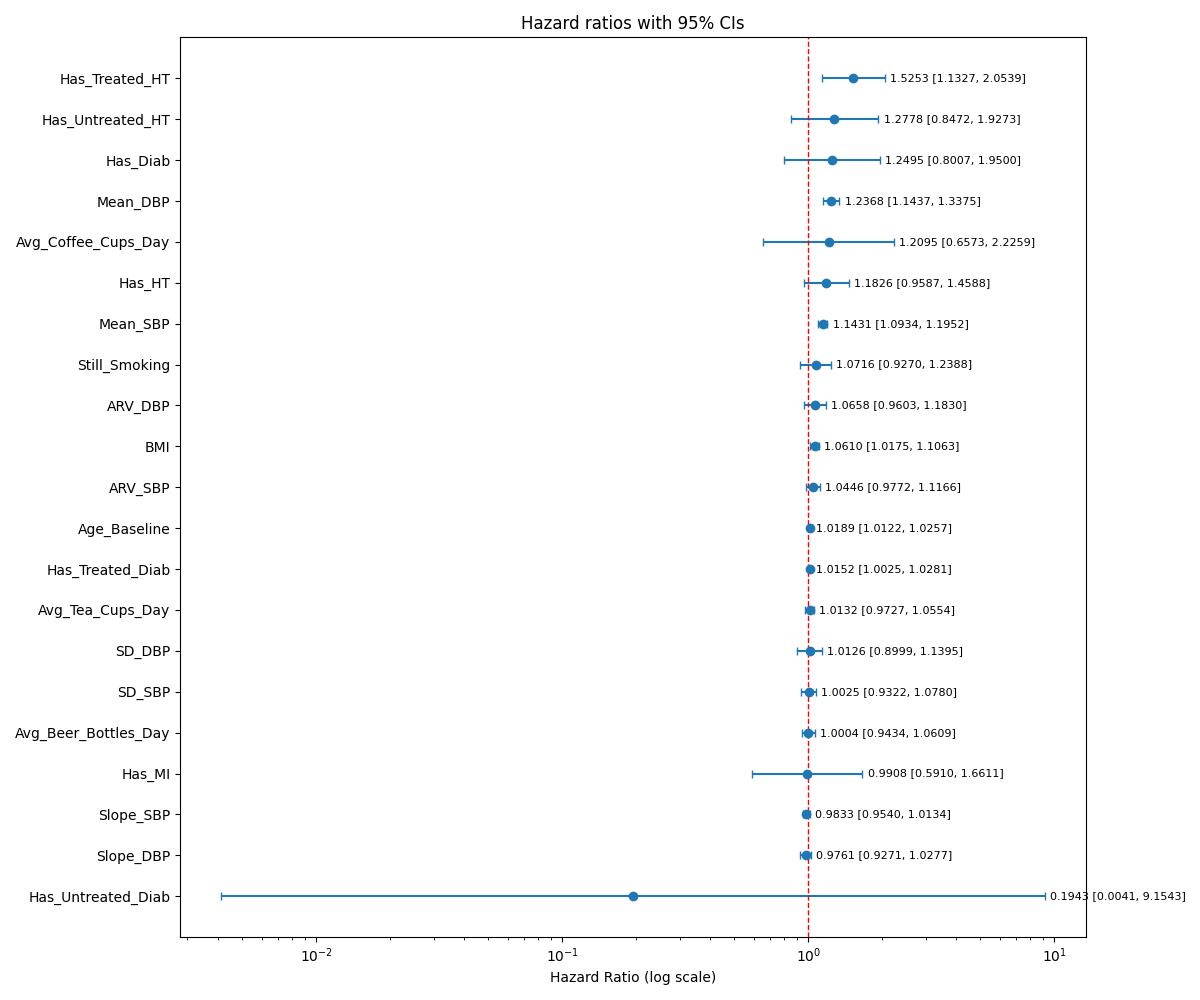

In [245]:
cph_df = df_person[['Time_Yrs', 'Event', 'Slope_SBP', 'Slope_DBP', 'Mean_SBP', 'Mean_DBP', 'SD_SBP', 'SD_DBP', 'ARV_SBP', 'ARV_DBP',
                    'Age_Baseline', 'BMI',
                    'Has_Untreated_HT', 'Has_Untreated_Diab',
                    'Has_Treated_HT', 'Has_Treated_Diab',
                    'Has_HT', 'Has_Diab', 'Has_MI',
                    'Still_Smoking',
                    'Avg_Beer_Bottles_Day', 'Avg_Coffee_Cups_Day', 'Avg_Tea_Cups_Day', ]].copy()
scale_map = {
    'Mean_SBP': 10.0,
    'Mean_DBP': 10.0,
    'SD_SBP': 10.0,
    'SD_DBP': 10.0,
    'ARV_SBP': 10.0,
    'ARV_DBP': 10.0,
    'BMI': 2.0
    # keep others at 1.0
}
evaluate_cox(cph_df, scale_map=scale_map, tight_layout=True)

(_results may vary or fluctuate_)

#### Hazard ratios of variables

From the results,

> **Note**
>
> `Had_TIA` was not included in the analysis, as its presence causes errors in the Cox model prediction phase.

##### 1. Statistically significant factors ($p < 0.05$, $-\log_2 p > 2.9957$)

1. Mean of DBP ($\beta = 0.0218$, $p < 5 \times 10^{-5}$)
2. Age at baseline ($\beta = 0.0192$, $p < 5 \times 10^{-5}$)
3. Mean of SBP ($\beta = 0.0141$, $p < 5 \times 10^{-5}$)
4. BMI ($\beta = 0.0326$, $p=0.0023$)
5. Whether the individual has HT under treatment ($\beta = 0.4222$, $p = 0.0054$)
5. Whether the individual has diabetes under treatment ($\beta = 0.2228$, $p = 0.0189$)

These factors agree with existing literature found.

##### 2. Valid predictors

Valid predictors are defined by predictors with both upper and lower hazard ratios under or over 1.

1. Mean DBP (HR = 1.2441 per 10 mmHg increase)
2. Mean SBP (HR = 1.1509 per 10 mmHg increase)
3. BMI (HR = 1.0673 per 2.0 increase in BMI)
4. Age at baseline (HR = 1.0189 per 1 year increase)
5. Whether the individual has HT under treatment (HT = 1.5253 if so)
5. Whether the individual has diabetes under treatment (HT = 1.0152 if so)

Additionally, slope of SBP and DBP are related to stroke risk, but with low statistical significance ($-\log_2 p = 2.5287$,
$p > 0.05$ respectively).

Meanwhile, variation in SBP and DBP (Standard Deviation and Average Real Variability of SBP and DBP) have little effect on stroke risk
($\beta < 0.0069$ per mmHg increase), but statistical significance is also low ($p > 0.05$), and their predictors in the Cox model are
not valid. Some life habit factors (consumption of beverages), have effect on stroke risk ($\beta$ for coffee drinking = 0.1991,
$\beta$ for tea drinking = 0.0163). However, their statistical significances are low ($p > 0.05$), and their predictors are not valid
in the Cox model. Having cardiovascular diseases, like HT, or having diabetes or MI, does affect the stroke risk, though having low
statistical significance ($p > 0.05$).

Therefore, by comparing trends of BP and stroke occurence, it can be seen that trends of BP (measured by slope of SBP and DBP) has no
statistically significant relation with stroke risk. However, it is true that for a generally high BP over the years (especially higher
DBP), can lead to a higher risk of stroke.

From results, if a proactive BP monitoring scheme were implemented, it should be prioritized for those who

1. Has higher DBP or SBP
2. Has HT conditions or diabetes conditions (under treatment)
3. Has higher BMI
4. Are older

, as such factors are more correlated with stroke risk than others.

#### Second rounds of Cox model

These evaluations tries to find correlation between the years of having a condition and stroke.

<lifelines.CoxPHFitter: fitted with 97 total observations, 0 right-censored observations>
             duration col = 'Time_Yrs'
                event col = 'Event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 97
number of events observed = 97
   partial log-likelihood = -349.9490
         time fit was run = 2025-12-29 01:31:07 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
TIA_Years 0.0011    1.0011    0.0110         -0.0204          0.0226              0.9798              1.0229

           cmp to      z      p  -log2(p)
covariate                                
TIA_Years  0.0000 0.1010 0.9195    0.1211
---
Concordance = 0.5294
Partial AIC = 701.8980
log-likelihood ratio test = 0.0103 on 1 df
-log2(p) of ll-ratio test = 0.1213

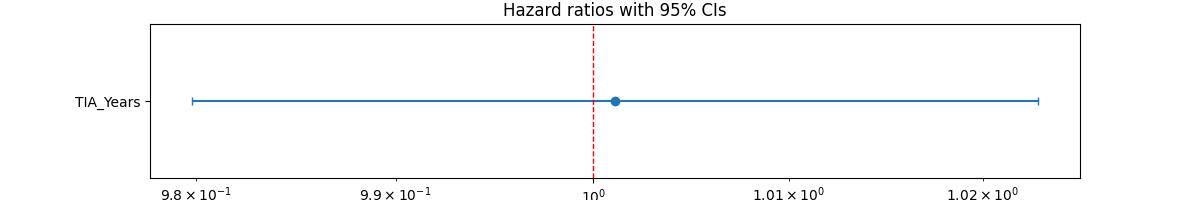

In [239]:
cph_df = df_person[['Time_Yrs', 'Event',
                   'TIA_Years']].copy()

evaluate_cox(cph_df, scale_map={}, tight_layout=False)

<lifelines.CoxPHFitter: fitted with 1728 total observations, 1514 right-censored observations>
             duration col = 'Time_Yrs'
                event col = 'Event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1728
number of events observed = 214
   partial log-likelihood = -1505.5523
         time fit was run = 2025-12-29 01:31:30 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
HT_Years  0.0002    1.0002    0.0023         -0.0044          0.0047              0.9956              1.0047

           cmp to      z      p  -log2(p)
covariate                                
HT_Years   0.0000 0.0785 0.9374    0.0932
---
Concordance = 0.5796
Partial AIC = 3013.1045
log-likelihood ratio test = 0.0062 on 1 df
-log2(p) of ll-ratio test = 0.0936

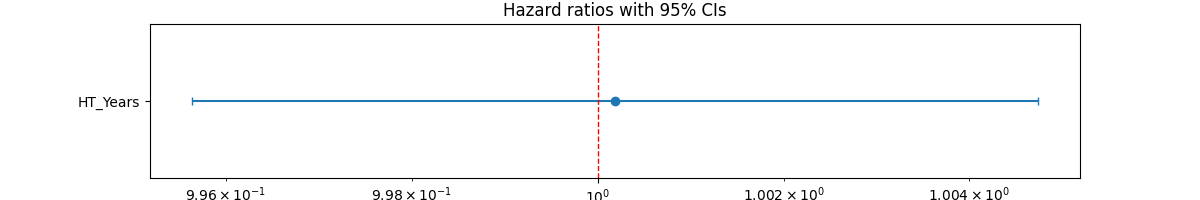

In [240]:
cph_df = df_person[['Time_Yrs', 'Event',
                   'HT_Years']].copy()

evaluate_cox(cph_df, scale_map={}, tight_layout=False)

<lifelines.CoxPHFitter: fitted with 339 total observations, 288 right-censored observations>
             duration col = 'Time_Yrs'
                event col = 'Event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 339
number of events observed = 51
   partial log-likelihood = -278.0051
         time fit was run = 2025-12-29 01:31:41 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
Diab_Years -0.0046    0.9955    0.0038         -0.0120          0.0029              0.9881              1.0029

            cmp to       z      p  -log2(p)
covariate                                  
Diab_Years  0.0000 -1.1979 0.2310    2.1142
---
Concordance = 0.4965
Partial AIC = 558.0102
log-likelihood ratio test = 1.2827 on 1 df
-log2(p) of ll-ratio test = 1.9579

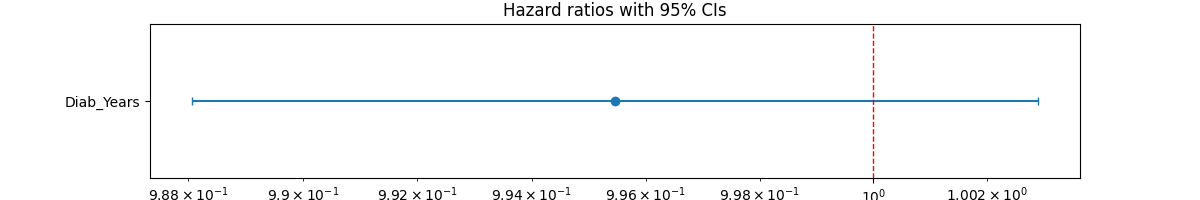

In [241]:
cph_df = df_person[['Time_Yrs', 'Event',
                   'Diab_Years']].copy()

evaluate_cox(cph_df, scale_map={}, tight_layout=False)

<lifelines.CoxPHFitter: fitted with 184 total observations, 145 right-censored observations>
             duration col = 'Time_Yrs'
                event col = 'Event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 184
number of events observed = 39
   partial log-likelihood = -183.8602
         time fit was run = 2025-12-29 01:31:55 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
MI_Years  -0.0043    0.9958    0.0088         -0.0215          0.0130              0.9787              1.0131

           cmp to       z      p  -log2(p)
covariate                                 
MI_Years   0.0000 -0.4837 0.6286    0.6697
---
Concordance = 0.4742
Partial AIC = 369.7204
log-likelihood ratio test = 0.2283 on 1 df
-log2(p) of ll-ratio test = 0.6602

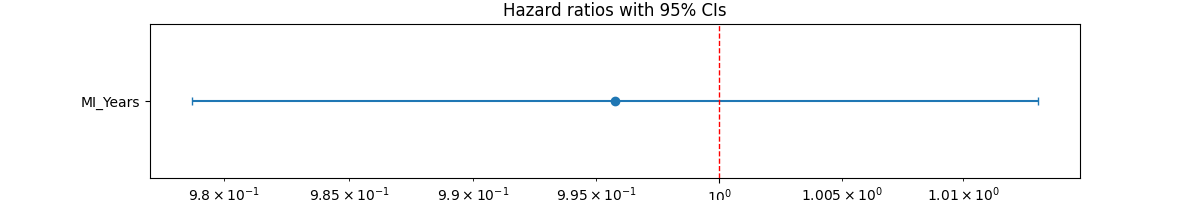

In [242]:
cph_df = df_person[['Time_Yrs', 'Event',
                   'MI_Years']].copy()

evaluate_cox(cph_df, scale_map={}, tight_layout=False)

#### Results

From the results, none of the years of having the conditions (HT, MI, TIA, Diabetes) shows statistically significant correlation with difference in 
stroke risk.
They are also not valid predictors in the Cox model.

### Assess effectiveness of HT and diabetes treatments

Since data is available on individuals receiving HT and diabetes treatments, it is possible to assess whether such treatments mediate
or reduce risks of stroke.

From results in first round of Cox model evaluation,

#### 1. HT under treatment is still associated with higher stroke risk.

   HT may contribute to a higher stroke risk. Having HT under treatment, however, does not eliminate this higher risk. Results show that
   having HT under treatment has around 52.53% higher stroke risk than others. On the other hand, predictors for untreated HT and HT alone
   are not valid, nor statistically significant.
#### 2. Diabetes under treatment is still associated with higher stroke risk.
   
   Diabetes may be associated with a higher stroke risk. However, diabetes under treatment of drugs does not eliminate this risk. Results
   show that diabetes under treatment has around 1.5% higher stroke risk than others. On the other hand, predictors for untreated diabetes
   and diabetes alone are not valid, nor statistically significant.

Therefore, from the results, treatment of HT and diabetes does not mediate or reduce stroke risk. Monitoring and stroke prevention strategies 
should be implemented primarily for population with such conditions, even if they are under treatment. 

### Recent symptoms and short-term stroke risk

This part will assess correlation between recent occurrence of symptoms and stroke events after them.

**Strategy**
For each person, find stroke event, and look for symptoms 1 wave before it. This creates a $2\times2$ contingency table like such,

|                | Symptom | No Symptom |
|----------------|---------|------------|
| **Stroke**     |   _a_   |     _b_    |
| **No stroke**  |   _c_   |     _d_    |

_a_ = stroke with symptom, _b_ = stroke without symptom,
_c_ = symptom but no stroke, _d_ = no symptom and no stroke.

A Fisher's exact test is run on this contingency table to produce odds ratio and a $p$-value.
Higher odds ratio ($\text{odds} \gg 1$) means that the symptom is much more likely to occur before stroke. Lower $p$ ($p < 0.05$) means such a result
is statistically significant.

Also, a Kaplan-Meier model was fit with population with symptom and those without. Such a model estimates survival probability of population with
variation of independent variable. Define survival as being free of stroke. A survival function (probability of being stroke-free) for both cases where the
symptom occured and did not occur were calculated and contrasted.

#### Feature extraction

This part calculates values for contigency table by counting _a_, _b_, _c_ and _d_ values as mentioned earlier, for each symptom in,

- `Headache_Last4` - Having a headache in last 4 weeks
- `Chestpain_Last4` - Having a chest pain in last 4 weeks
- `Exhausion_Last4` - Feeling exhaustion in last 4 weeks
- `Unknown_Bleed_Last4` - Had unknown bleeding in last 4 weeks
- `Unknown_WghtLoss_Last4` - Had weight loss of unknown cause in last 4 weeks
- `Had_TIA` - Having TIA in last year

, in one wave before stroke occured.

In [95]:
symptom_names = [
    'Headache_Last4', 'Chestpain_Last4', 'Exhaustion_Last4',
    'Unknown_Bleed_Last4', 'Unknown_WghtLoss_Last4',
    'Had_TIA'
]

# Count at stroke waves
stroke_symptom_counts = {symptom: [0, 0] for symptom in symptom_names}
num_stroke = 0

for pid, df in persons.items():
    df = df.sort_values('Wave').reset_index(drop=True)
    stroke_idx = df.index[df['Has_Apopl'] == 1].tolist()
    if stroke_idx:
        idx = stroke_idx[0]
        symptoms_present = df.loc[idx, symptom_names]
        if not symptoms_present.isnull().all():
            num_stroke += 1
            for s in symptom_names:
                if symptoms_present[s] == 1:
                    stroke_symptom_counts[s][0] += 1
                else:
                    stroke_symptom_counts[s][1] += 1

# Count at non-stroke waves
symptom_any_nostroke = {symptom: [0, 0] for symptom in symptom_names}
total_nostroke = 0
for pid, df in persons.items():
    df = df.sort_values('Wave').reset_index(drop=True)
    nostroke_df = df[df['Has_Apopl'] == 0]
    total_nostroke += len(nostroke_df)
    for s in symptom_names:
        n_present = (nostroke_df[s] == 1).sum()
        n_absent = (nostroke_df[s] == 0).sum()
        symptom_any_nostroke[s][0] += n_present
        symptom_any_nostroke[s][1] += n_absent

In [96]:
# Output contingency tables for each symptom
for s in symptom_names:
    print(f"\nSymptom: {s}")
    table = pd.DataFrame({
        'Stroke': stroke_symptom_counts[s],
        'No Stroke': symptom_any_nostroke[s]
    }, index=['Symptom', 'No Symptom'])
    display(table)

    total = table.sum(axis=1)
    print(f"Strokes with symptom: {stroke_symptom_counts[s][0]} / {num_stroke} ({stroke_symptom_counts[s][0] / num_stroke:.2%})")
    nostroke_total = symptom_any_nostroke[s][0] + symptom_any_nostroke[s][1]
    print(f"No-stroke waves with symptom: {symptom_any_nostroke[s][0]} / {nostroke_total} ({symptom_any_nostroke[s][0] / nostroke_total:.2%})")


Symptom: Headache_Last4


,Stroke,No Stroke
Symptom,41,1648
No Symptom,263,27922


Strokes with symptom: 41 / 304 (13.49%)
No-stroke waves with symptom: 1648 / 29570 (5.57%)

Symptom: Chestpain_Last4


,Stroke,No Stroke
Symptom,24,583
No Symptom,280,28991


Strokes with symptom: 24 / 304 (7.89%)
No-stroke waves with symptom: 583 / 29574 (1.97%)

Symptom: Exhaustion_Last4


,Stroke,No Stroke
Symptom,6,97
No Symptom,298,29485


Strokes with symptom: 6 / 304 (1.97%)
No-stroke waves with symptom: 97 / 29582 (0.33%)

Symptom: Unknown_Bleed_Last4


,Stroke,No Stroke
Symptom,0,6
No Symptom,304,29576


Strokes with symptom: 0 / 304 (0.00%)
No-stroke waves with symptom: 6 / 29582 (0.02%)

Symptom: Unknown_WghtLoss_Last4


,Stroke,No Stroke
Symptom,0,4
No Symptom,304,29578


Strokes with symptom: 0 / 304 (0.00%)
No-stroke waves with symptom: 4 / 29582 (0.01%)

Symptom: Had_TIA


,Stroke,No Stroke
Symptom,21,0
No Symptom,283,29582


Strokes with symptom: 21 / 304 (6.91%)
No-stroke waves with symptom: 0 / 29582 (0.00%)


#### Fisher's exact test for enrichment

Calculate odds ratio and $p$-value.

In [98]:
rows = []
for s in symptom_names:
    # Build the 2x2 table: [ [stroke+symptom, stroke+no_symptom], [nostroke+symptom, nostroke+no_symptom] ]
    stroke_with_symptom = stroke_symptom_counts[s][0]
    stroke_without_symptom = stroke_symptom_counts[s][1]
    nostroke_with_symptom = symptom_any_nostroke[s][0]
    nostroke_without_symptom = symptom_any_nostroke[s][1]

    # 2x2 contingency table for Fisher's test
    table = [
        [stroke_with_symptom, stroke_without_symptom],
        [nostroke_with_symptom, nostroke_without_symptom]
    ]
    oddsratio, pvalue = stats.fisher_exact(table)

    # Save both the table and the association stats
    rows.append([
        oddsratio,
        pvalue,
        f"{stroke_with_symptom} / {stroke_with_symptom + stroke_without_symptom}",     # Strokes with symptom / all strokes
        f"{nostroke_with_symptom} / {nostroke_with_symptom + nostroke_without_symptom}", # No-strokes with symptom / all no-stroke waves
    ])

out_fisher_df = pd.DataFrame(rows, columns=[
    "Odds ratio",
    "$p$",
    "Stroke/Total at Stroke",
    "No-Stroke/Total No-Stroke",
])
out_fisher_df.index = symptom_names
out_fisher_df = out_fisher_df.sort_values("Odds ratio", ascending=False)
out_fisher_df

,Odds ratio,$p$,Stroke/Total at Stroke,No-Stroke/Total No-Stroke
Had_TIA,inf,7.105383e-43,21 / 304,0 / 29582
Exhaustion_Last4,6.120183,6.599578e-04,6 / 304,97 / 29582
Chestpain_Last4,4.262338,1.919342e-08,24 / 304,583 / 29574
Headache_Last4,2.641298,2.521117e-07,41 / 304,1648 / 29570
Unknown_Bleed_Last4,0.000000,1.000000e+00,0 / 304,6 / 29582
Unknown_WghtLoss_Last4,0.000000,1.000000e+00,0 / 304,4 / 29582


#### Kaplan-Meier analysis of survival probability

Define survive as being stroke-free. The Kaplan-Meier model fitted here estimates the probablily of being free from stroke, if one of the symptoms
mentioned earlier show up.

,Headache_Last4 EVER (n=1337),Headache_Last4 NEVER (n=3950)
timeline,,
0.0,1.0000,1.0000
22.0,0.8694,0.9299


,Chestpain_Last4 EVER (n=482),Chestpain_Last4 NEVER (n=4805)
timeline,,
0.0,1.0000,1.0000
22.0,0.8193,0.9193


,Exhaustion_Last4 EVER (n=101),Exhaustion_Last4 NEVER (n=5186)
timeline,,
0.0,1.0000,1.0000
22.0,0.8668,0.9116


,Unknown_Bleed_Last4 EVER (n=6),Unknown_Bleed_Last4 NEVER (n=5281)
timeline,,
0.0,1.0,1.0


,Unknown_WghtLoss_Last4 EVER (n=4),Unknown_WghtLoss_Last4 NEVER (n=5283)
timeline,,
0.0,1.0,1.0


,Had_TIA EVER (n=31),Had_TIA NEVER (n=5256)
timeline,,
0.0,1.0,1.0000
22.0,0.0,0.9254


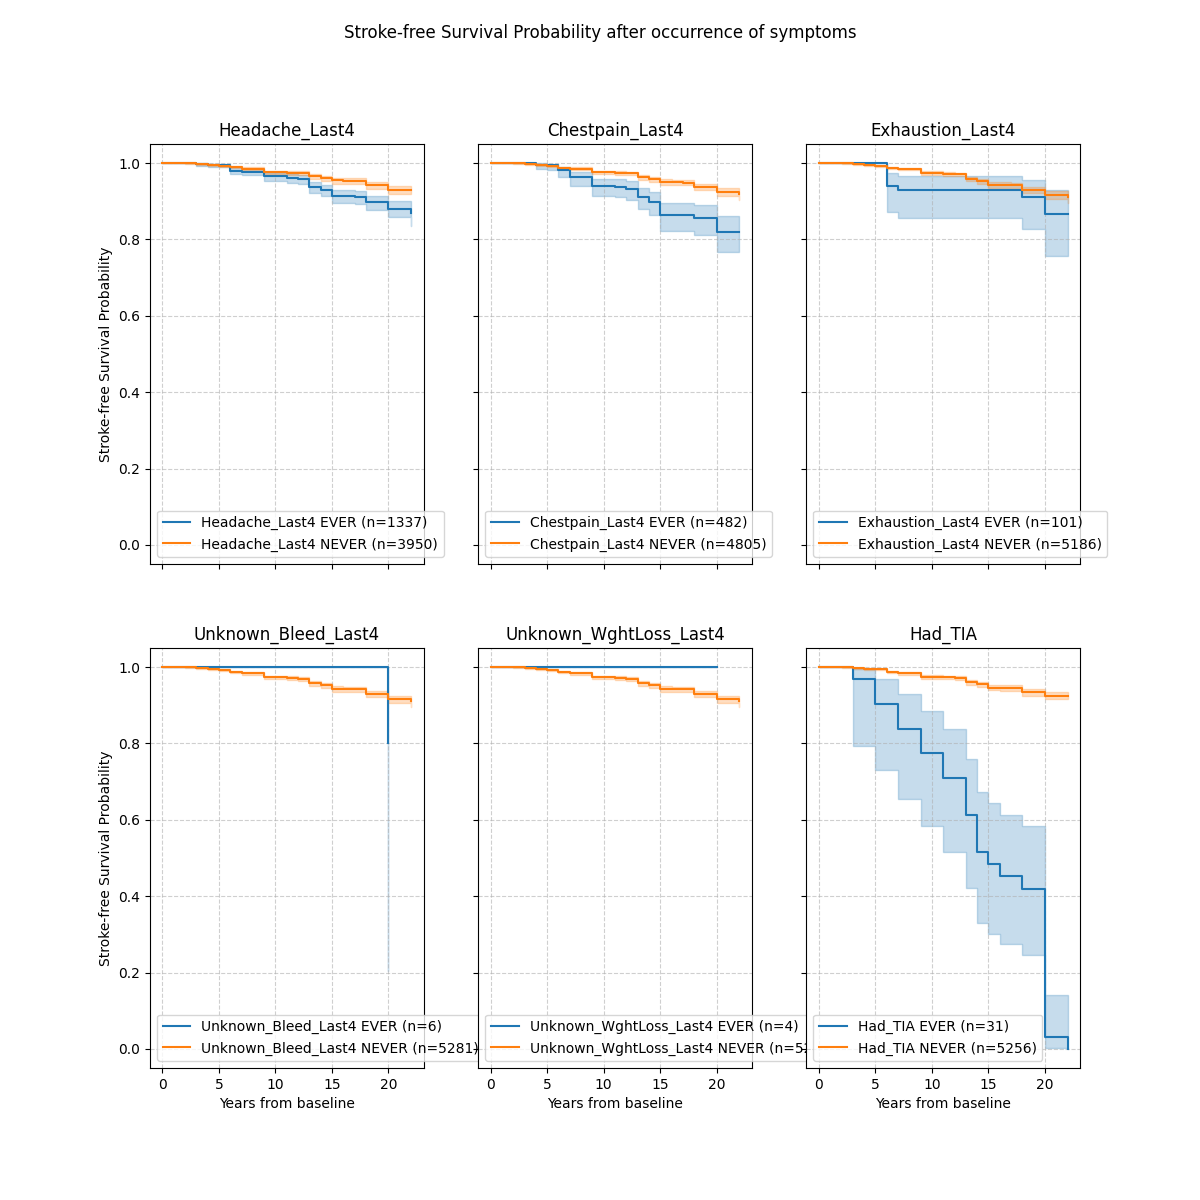

In [140]:
kmf = KaplanMeierFitter()
fig, axes = plt.subplots(2, 3, figsize=(12, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, s in enumerate(symptom_names):
    ax = axes[i]

    # Plot two curves: ever had symptom vs never had symptom
    group_labels = [f"{s} EVER", f"{s} NEVER"]
    survive_df = None
    for val, label, color in zip([1,0], group_labels, ['tab:red', 'tab:blue']):
        mask = df_symptom_ever[s + '_EVER'] == val
        if mask.sum() > 0:
            kmf.fit(df_symptom_ever.loc[mask,"Time_Yrs"], event_observed=df_symptom_ever.loc[mask,"Event"], label=f"{label} (n={mask.sum()})")
            kmf.plot_survival_function(ax=ax, ci_show=True)

            current_survive_df = kmf.survival_function_.iloc[[0, -1]]
            if survive_df is None:
                survive_df = current_survive_df
            else:
                # Show survival function (start and end)
                survive_df = survive_df.merge(current_survive_df, on="timeline")
                survive_df = survive_df.round(4)
                display(survive_df)
    ax.set_title(s)
    ax.set_xlabel("Years from baseline")
    ax.set_ylabel("Stroke-free Survival Probability")
    ax.grid(True, linestyle='--', alpha=0.6)

plt.suptitle("Stroke-free Survival Probability after occurrence of symptoms")
plt.show()

From the results,

#### Statistically significant symptoms associated with stroke

1. **Had TIA** ($\text{odds} \gg 1$, $p \ll 0.05$)

   Having TIA symptoms in 1-year window before survey is related very greatly with stroke risk in the subsequent wave. As shown by odds ratio being infinity,
   it means that all 21 individuals surveyed with TIA developed stroke in a subsequent wave. Statistically, this result is very significant, shown by the
   very low $p$ value.

   This agrees with existing literature about risk factors of stroke, where individuals having TIA are extremely likely to develop stroke subsequently.

   Survival probability decreases to 0% at 22 years. This is the highest rate of decrease of stroke-free population, meaning that ever having TIA means
   almost certainty of developing stroke.

2. **Exhaustion** ($\text{odds} = 6.1202$, $p < 0.05$)

   Exhaustion in 4-week window before survey is related to more than 6 times higher stroke risk in the subsequent wave, and is statistically significant.

   Survival function of it shows the survival probability decreased to 0.8668 at 22 years with exhaustion present, compared to 0.9116 with it absent. The 
   difference is around 4%.

   However, exhaustion as a "symptom" is not a specific description. Also, only 6 individuals out of 304 with stroke experienced exhaustion in 4-month
   windows 1 wave before stroke. This result should be taken with a grain of salt.

3. **Chest pain** ($\text{odds} = 4.2623$, $p \ll 0.05$)

   Chest pain in 4-week window before survey is related to more than 4 times higher stroke risk in the subsequent wave, and is statistically significant.

   Its survival function shows the survival probability decreased to 0.8193 at 22 years with exhaustion present, compared to 0.9193 with it absent. The 
   difference is around 10%, which is the greatest among all.

   Clinically, chest pain may indicate cardiovascular issues.
   Some of which, like HT (under treatment), has been proven to be correlated with a higher stroke risk.

4. **Headache** ($\text{odds} = 2.6413$, $p \ll 0.05$)

   Headache in 4-week window before survey is related to more than 2 times higher stroke risk in the subsequent wave, and is statistically significant.

   Its survival function shows the survival probability decreased to 0.8694 at 22 years with exhaustion present, compared to 0.9299 with it absent. The 
   difference is around 10%, which is the greatest among all.

For 2 other symptoms, which are having bleeding of unknown cause and having weight loss of unknown cause, not enough data are available to support any
claims to be made, as survival functions for cases where each symptom is present and absent are not complete.

Therefore, adding to the criteria for population prioritized for BP monitoring, such schemes should be prioritized for

1. Population who have had a TIA in recent years, and,
2. Population who shows symptoms of headache, chest pain, and exhaustion in recent years.

### Evaluate criteria for monitoring scheme

In previous sections, the following criteria for prioritized access to BP monitoring schemes are found,

1. Population with higher DBP or SBP
2. Population with HT conditions or diabetes conditions (under treatment)
3. Population with higher BMI
4. Older population
5. Population who have had a TIA in recent years
6. Population who shows symptoms of headache, chest pain, and exhaustion in recent years.

To facilitate applying the criteria, a binary classification method based on determined cut-offs shall be used.
However, cut-offs for these criteria must be found to facilitate applying them.
This part finds optimal cut-offs for criteria, that satisfies the following,

- **Being easy to apply**
  
  Have a clear cut-off with binary classification
- **Minimizes enforcement workload (WUD)**

  The criteria should flag a manageable portion of the population as positive. This is judged from two factors, Work-up to detection (WUD) and population
  yield. Both should be kept at a manageable level, i.e., $\text{WUD} < 10$, $\text{Population yield} \approx 30\%-50\%$.
  
  WUD is defined as the number of people to flag and monitor, in order to catch one true positive case (having stroke).
  Mathematically, it is defined as

  $$ \text{WUD} = \frac{1}{\text{PPV}} $$

  It can be seen that the smaller this value is, the smaller the population is needed to screen to detect true positive cases, and thus the smaller
  the workload to enfore such criteria.
- **Maximizes Positive Predictive Value (PPV)**

  Positive Predictive Value (PPV) is defined as the probability that a person who tests positive (predicted higher stroke risk) is actually positive
  (develops stroke).

  Mathematically, it is defined as,

  $$ \text{PPV} = \frac{\text{TP}}{\text{TP} + \text{FP}} $$

  TP = True positive, FP = false positive. In other words, it measures the rate of true positives among all positive detections.
- **Maximizes Sensitivity**

  Higher sensitivity means a higher rate of predicting actual future strokes.

The following factors require finding optimal cut-offs,

1. Population with higher DBP or SBP (cut-off DBP and SBP measured in mmHg)
2. Population with higher BMI (cut-off BMI value)
3. Older population (cut-off age)
4. Population who have had a TIA in recent years (cut-off time range to trace back)
5. Population who shows symptoms of headache, chest pain, and exhaustion in recent years (cut-off time range to trace back).

**Strategy**
This part will iterate through a range of cut-offs, and run a function to evaluate their performance. The following factors are considered,

- **Youden's index**, calculated by
    - **Sensitivity** - True positive rate
    - **Specificity** - True negative rate
- **PPV**
- **Population yield** - Population flagged positive

Youden's index is defined as

$$ J = \text{Sensitivity} + \text{Specificity} − 1 $$

In [142]:
def evaluate_cutoff(var, cutoffs, compare, df, outcome='Event'):
    perf_rows = []
    for cutoff in cutoffs:
        if compare == 'geq':
            flag = df[var] >= cutoff
        elif compare == 'leq':
            flag = df[var] <= cutoff
        else:
            raise ValueError("compare must be 'geq' or 'leq'")
        TP = ((flag) & (df[outcome]==1)).sum()
        FP = ((flag) & (df[outcome]==0)).sum()
        FN = ((~flag) & (df[outcome]==1)).sum()
        TN = ((~flag) & (df[outcome]==0)).sum()
        sensitivity = TP / (TP+FN) if (TP+FN)>0 else np.nan
        specificity = TN / (TN+FP) if (TN+FP)>0 else np.nan
        PPV = TP / (TP+FP) if (TP+FP)>0 else np.nan
        PopulationYield = flag.mean()
        youden = sensitivity + specificity - 1 if not (np.isnan(sensitivity) or np.isnan(specificity)) else np.nan
        perf_rows.append(dict(Cutoff=cutoff, Sensitivity=sensitivity, Specificity=specificity, PPV=PPV, PopulationYield=PopulationYield, Youden=youden))
    return pd.DataFrame(perf_rows)


>>> SBP Youden-optimal cutoff:
Cutoff             130.000000
Sensitivity          0.677632
Specificity          0.688140
PPV                  0.117045
PopulationYield      0.332892
Youden               0.365771
Name: 5, dtype: float64


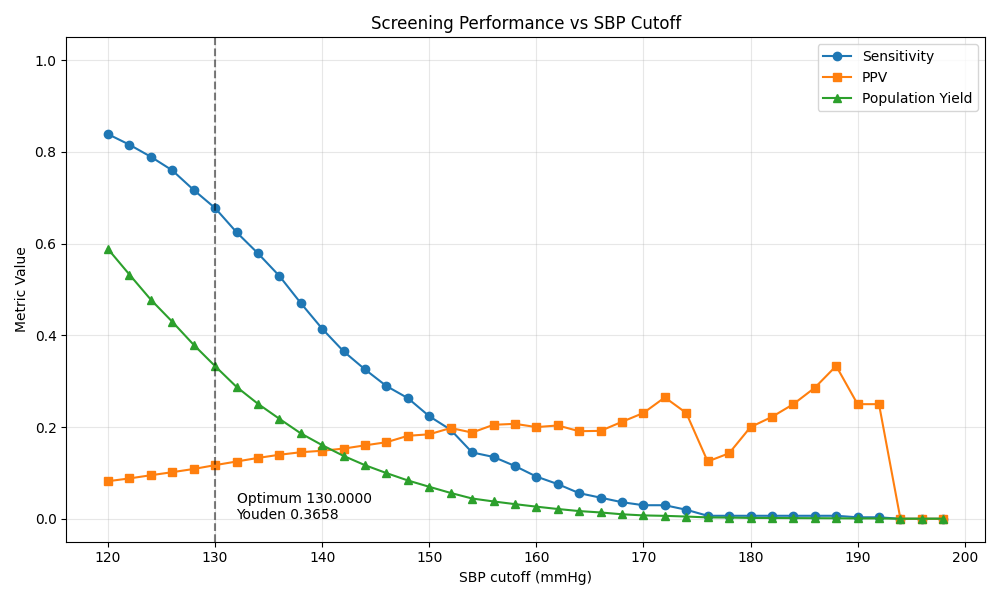


>>> DBP Youden-optimal cutoff:
Cutoff             82.000000
Sensitivity         0.634868
Specificity         0.682119
PPV                 0.108610
PopulationYield     0.336107
Youden              0.316988
Name: 11, dtype: float64


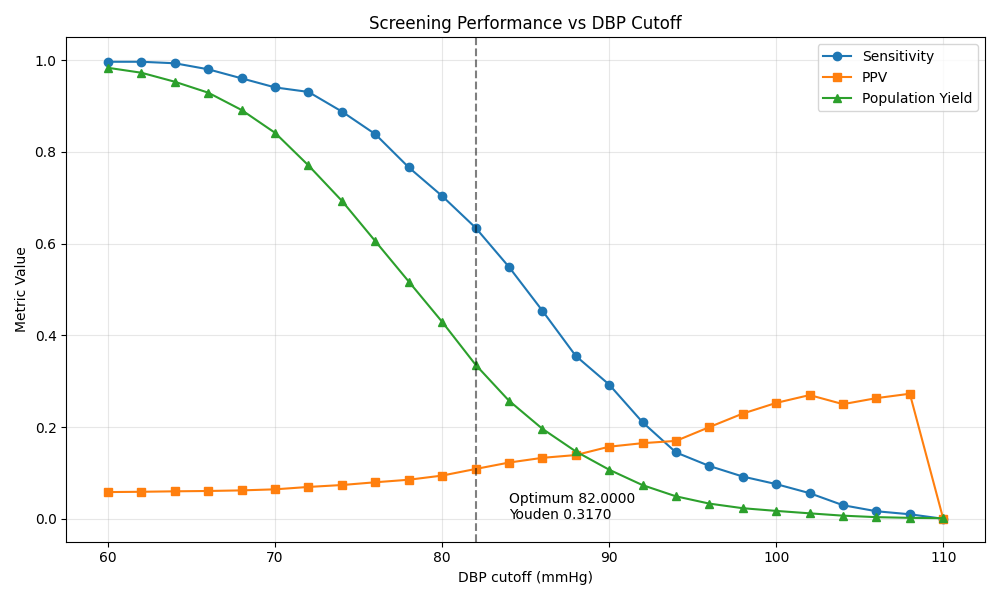


>>> BMI Youden-optimal cutoff:
Cutoff             22.000000
Sensitivity         0.644737
Specificity         0.505719
PPV                 0.073712
PopulationYield     0.502932
Youden              0.150456
Name: 6, dtype: float64


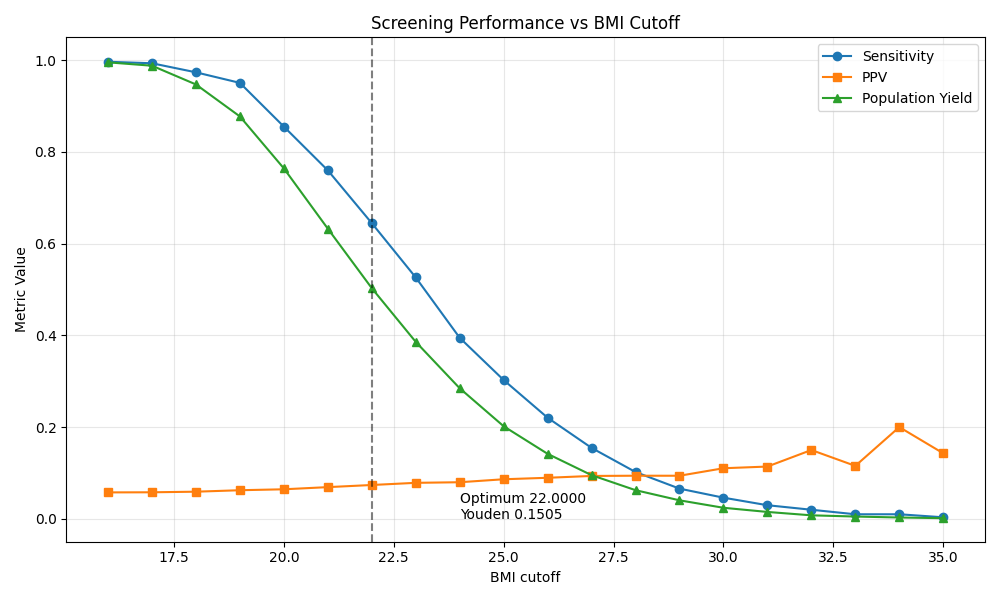


>>> Age Youden-optimal cutoff:
Cutoff             53.000000
Sensitivity         0.605263
Specificity         0.568332
PPV                 0.078801
PopulationYield     0.441649
Youden              0.173595
Name: 3, dtype: float64


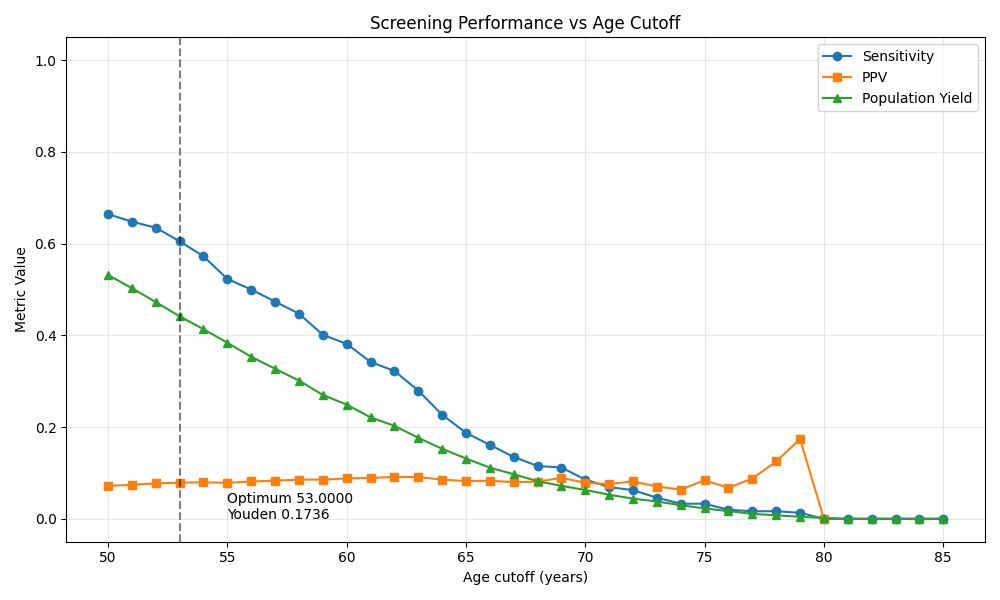

In [157]:
# Prepare test values
sbp_cutoffs = np.arange(120, 200, 2)
dbp_cutoffs = np.arange(60, 111, 2)
bmi_cutoffs = np.arange(16, 36, 1)
age_cutoffs = np.arange(50, 86, 1)
tia_lookback = np.arange(1, 11, 1)

df_perf_sbp  = evaluate_cutoff('Mean_SBP', sbp_cutoffs, compare='geq', df=df_person)
df_perf_dbp  = evaluate_cutoff('Mean_DBP', dbp_cutoffs, compare='geq', df=df_person)
df_perf_bmi  = evaluate_cutoff('BMI',      bmi_cutoffs, compare='geq', df=df_person)
df_perf_age  = evaluate_cutoff('Age_Baseline', age_cutoffs, compare='geq', df=df_person)

### 2. Plot for each variable

def plot_perf(df_perf, varname, xlabel, optimal_df=None):
    plt.figure(figsize=(10,6))
    plt.plot(df_perf['Cutoff'], df_perf['Sensitivity'], label='Sensitivity', marker='o')
    plt.plot(df_perf['Cutoff'], df_perf['PPV'], label='PPV', marker='s')
    plt.plot(df_perf['Cutoff'], df_perf['PopulationYield'], label='Population Yield', marker='^')
    plt.xlabel(xlabel)
    plt.ylabel("Metric Value")
    plt.title(f"Screening Performance vs {varname} Cutoff")
    plt.ylim(-0.05, 1.05)
    plt.legend()
    plt.grid(alpha=0.3)
    if optimal_df is not None:
        optimal_label = optimal_df["Cutoff"]
        youden = optimal_df["Youden"]
        
        plt.axvline(optimal_label, color='black', linestyle='--', alpha=0.5)
        plt.text(optimal_label + 2, 0, f"Optimum {optimal_label:.4f}\nYouden {youden:.4f}")
    plt.tight_layout()
    plt.show()

# For each variable, find and print Youden-optimal cut and plot
for name, df_perf, xlabel in [
    ('SBP', df_perf_sbp, 'SBP cutoff (mmHg)'),
    ('DBP', df_perf_dbp, 'DBP cutoff (mmHg)'),
    ('BMI', df_perf_bmi, 'BMI cutoff'),
    ('Age', df_perf_age, 'Age cutoff (years)'),
    # ('Years since TIA', df_perf_TIA, 'Years since TIA (<=)'),
]:
    idx = df_perf['Youden'].idxmax()
    print(f"\n>>> {name} Youden-optimal cutoff:")
    optimal_df = df_perf.loc[idx]
    print(optimal_df)
    plot_perf(df_perf, name, xlabel, optimal_df=optimal_df)

## AI usage note

This project was completed with the help of AI to,

- Refine language
- Suggest suitable data analysis methods
- Generate boilerplate code for analysis
- Help understand statistical concepts
- Parse literature data found manually

## References

```
Centers for Disease Control and Prevention. (2024, May 15). Risk factors for stroke. Centers for Disease Control and Prevention. https://www.cdc.gov/stroke/risk-factors/index.html
Boehme, A. K., Esenwa, C., & Elkind, M. S. (2017). Stroke Risk Factors, Genetics, and Prevention. Circ Res, 120(3), 472–495. https://doi.org/10.1161/circresaha.116.308398 
Centre for Health Prevention. (2025). Non-Communicable Diseases Watch October 2025 - Be Stroke Aware. Centre for Health Prevention. https://www.chp.gov.hk/files/pdf/ncd_watch_oct_2025_en.pdf
Han, T. S., Wang, H. H., Wei, L., Pan, Y., Ma, Y., Wang, Y., Wang, J., Hu, Z., Sharma, P., & Chen, R. (2017). Impacts of undetected and inadequately treated hypertension on incident stroke in China. BMJ Open, 7(10), e016581. https://doi.org/10.1136/bmjopen-2017-016581
```